<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting" data-toc-modified-id="Setting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting</a></span><ul class="toc-item"><li><span><a href="#Path" data-toc-modified-id="Path-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Path</a></span></li></ul></li><li><span><a href="#時系列データ作成" data-toc-modified-id="時系列データ作成-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>時系列データ作成</a></span><ul class="toc-item"><li><span><a href="#No-Noise" data-toc-modified-id="No-Noise-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>No Noise</a></span></li><li><span><a href="#Noise" data-toc-modified-id="Noise-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Noise</a></span></li></ul></li><li><span><a href="#入力データ作成" data-toc-modified-id="入力データ作成-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>入力データ作成</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Fit" data-toc-modified-id="Fit-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Fit</a></span></li></ul></li><li><span><a href="#Save-Model" data-toc-modified-id="Save-Model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Save Model</a></span></li></ul></li><li><span><a href="#history" data-toc-modified-id="history-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>history</a></span></li></ul></div>

# create_Conv1d_model__SinCosFunc

1. データ作成
  - 単なるsin関数を含んだ式
  - ノイズを加える
  - 異常波形作成
1. CNN時系列予測
  - [時系列予測を一次元畳み込みを使って解く with Keras - Qiita
      ](https://qiita.com/niisan-tokyo/items/a94dbd3134219f19cab1)
  - その背景を $windowsize$ 5-60程度で予測するConv1d層の作成

In [1]:
ipynb_title = "create_Conv1d_model__SinCosFunc"

In [2]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

import keras
print("Keras version : ", keras.__version__)

Using TensorFlow backend.


Keras version :  2.2.0


## Setting

### Path

In [3]:
HOME = Path(os.getcwd()).parent
print(HOME)

/home/sugihiro/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku


In [4]:
path_list = []
keras_model_h5_Path = HOME / "keras_model_h5_Path"
path_list.append(keras_model_h5_Path)
data_Path = HOME / "data"
path_list.append(data_Path)
plot_images_Path = data_Path / "plot_images"
path_list.append(plot_images_Path)

for _Path in path_list:
    _path = str(keras_model_h5_Path)
    if not os.path.exists(_path):
        os.makedirs(name=_path)
        print("make a directory: \n\t", _path)
    else:
        print(os.path.exists(_path), ": ", _path)

True :  /home/sugihiro/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5_Path
True :  /home/sugihiro/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5_Path
True :  /home/sugihiro/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5_Path


## 時系列データ作成

$$
\textbf{toyfunc(t)} = 
  \text{triAmpl} \cdot \left( 
    \sin\left( \frac{2\pi}{T} t \right) + \cos\left( 2 \cdot \frac{2\pi}{T} t \right) + \sin\left( 3 \cdot \frac{2\pi}{T} t \right) + \cos\left( 4 \cdot \frac{2\pi}{T} t \right) \right)
  + \text{tAmpl} \cdot t + \varepsilon
$$

$$
T\text{は周期, triAmpl, tAmplは係数, } \varepsilon \text{は平均}0 \text{,分散}1 \text{の正規分布に従うノイズ}
$$ 

- <a href="https://ja.wikipedia.org/wiki/%E3%83%9B%E3%83%AF%E3%82%A4%E3%83%88%E3%83%8E%E3%82%A4%E3%82%BA">ホワイトノイズ - Wikipedia</a>
- <a href="https://ja.wikipedia.org/wiki/%E4%B9%B1%E6%95%B0%E5%88%97#%E6%AD%A3%E8%A6%8F%E4%B9%B1%E6%95%B0">乱数列 - Wikipedia</a>

In [5]:
def mySin(t, period=100):
    """
    時刻t, 周期period
    """
    return np.sin(2.0 * np.pi * t/period)

def myCos(t, period=100):
    """
    時刻t, 周期period
    """
    return np.cos(2.0 * np.pi * t/period)

### No Noise

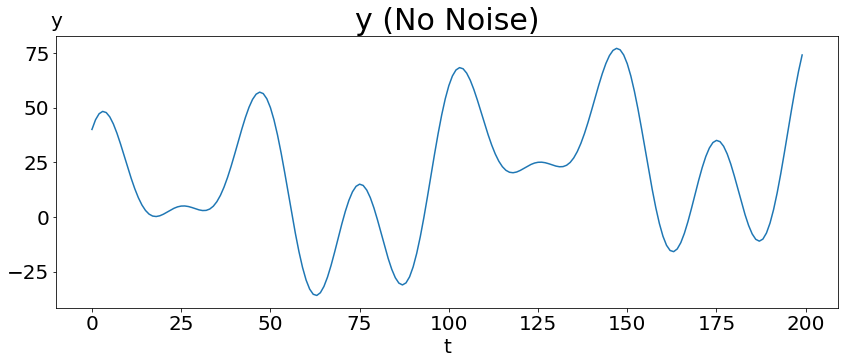

In [6]:
# No Noise
t = np.arange(start=0, stop=200, step=1)
triAmpl = 20
tAmpl = 0.2
y = triAmpl * ( mySin(t, period=100)
                + mySin(t=3*t, period=100)
                + myCos(t=2*t, period=100)
                + myCos(t=4*t, period=100) ) + tAmpl * t

#----------
# Plot
#----------
fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)

ax.plot(t, y)

title = "y (No Noise)"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0., y=1.02)
ax.tick_params(labelsize=20)

plt.show()

### Noise


In [7]:
# Add Noise
def toy_func(tStart=0, tStop=100, tStep=1, triAmpl=20, tAmpl=0.5, noiseAmpl=0.05):
    """
    T : sin波の周期
    ampl : ノイズ振幅調整
    triAmpl : 三角関数の係数(振幅)
    tAmpl : tの一次の係数
    noiseAmpl : ノイズの係数(振幅)
      """
    t = np.arange(start=tStart, stop=tStop, step=tStep)
    noise = np.random.randn(t.shape[0])  # mean=0, standard_deviation=1
    return (t,
            triAmpl * ( mySin(t, period=100)
                        + mySin(t=3*t, period=100)
                        + myCos(t=2*t, period=100)
                        + myCos(t=4*t, period=100) )
            + tAmpl * t
            + noiseAmpl * noise )

$$
\textbf{toyfunc(t)} = 
  \frac{1}{4} \cdot \left( 
    \sin\left( \frac{2\pi}{T} t \right) + \cos\left( 2 \cdot \frac{2\pi}{T} t \right) + 
    \sin\left( 3 \cdot \frac{2\pi}{T} t \right) + \cos\left( 4 \cdot \frac{2\pi}{T} t \right) 
   \right) + 0.1 \cdot \varepsilon
$$

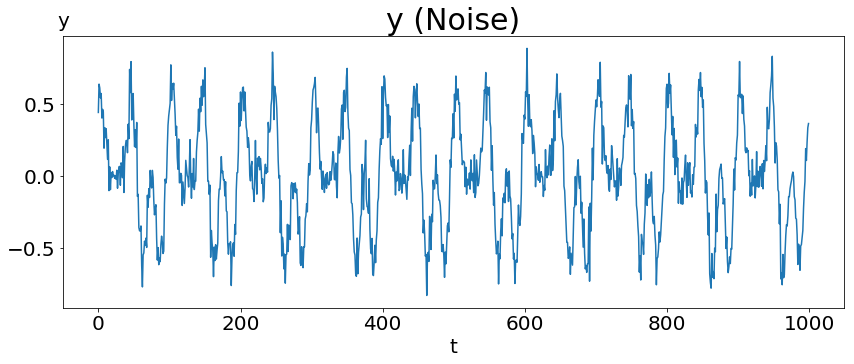

In [8]:
filename = ipynb_title + "__wave_with_noise.png"

fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)
t, y = toy_func(tStop=1000, triAmpl=1./4, tAmpl=0.0, noiseAmpl=0.1)
ax.plot(t, y)

title = "y (Noise)"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0.0, y=1.02)
ax.tick_params(labelsize=20)

fig.savefig(fname=str(plot_images_Path / filename))
plt.show()

## 入力データ作成

<img src="images/create_input_data.gif" style="width: 70%; height: 70%">

In [9]:
#----------------------------------------
# Parameters
#----------------------------------------
windowsize = 60
predictsize = 1
sample_data_size = 10000
trainsize = 10000

#----------------------------------------
# Sample Wave
#----------------------------------------
t, sample_wave = toy_func(tStop=sample_data_size, triAmpl=1./4, tAmpl=0.0, noiseAmpl=0.1)
print(sample_wave.shape)

(10000,)


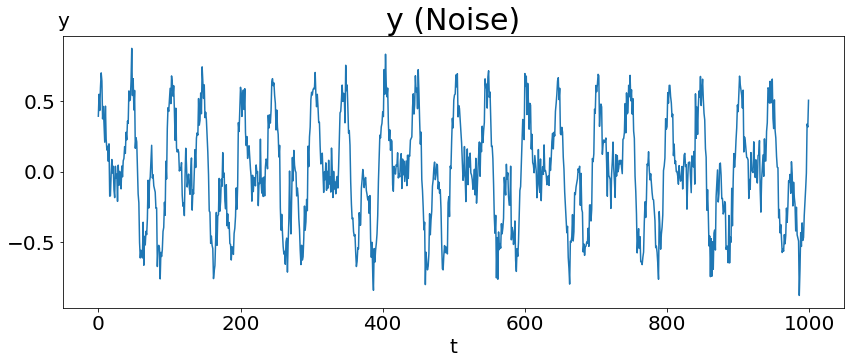

In [10]:
#----------------------------------------
# plot sample wave
#----------------------------------------
filename = ipynb_title + "__wave_with_noise.png"

fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)
ax.plot(t[:1000], sample_wave[:1000])

title = "y (Noise)"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0.0, y=1.02)
ax.tick_params(labelsize=20)

fig.savefig(fname=str(plot_images_Path / filename))
plt.show()

In [11]:
#----------------------------------------
# create input data
#----------------------------------------
input_data  = np.empty(shape=(0, windowsize))
output_data = np.empty(shape=(0, predictsize))
print(input_data.shape)
print(output_data.shape)
for i in range( sample_wave.shape[0] - (windowsize + predictsize) + 1 ):
    input_data = np.append(arr   =input_data,
                           values=sample_wave[i:(i+windowsize)].reshape(1, -1),
                           axis  =0)
    output_data = np.append(arr   =output_data,
                            values=sample_wave[(i+windowsize):(i+windowsize+predictsize)].reshape(1, -1),
                            axis  =0)
print("input_data.shape  : ", input_data.shape)
print("output_data.shape : ", output_data.shape)
#--------------------
# Kerasのモデルに入力できる形にするためにreshapeして次元を足す
#--------------------
input_data = input_data.reshape((-1, windowsize, 1))
output_data = output_data.reshape((-1, predictsize, 1))
print("input_data.shape  : ", input_data.shape)
print("output_data.shape : ", output_data.shape)

(0, 60)
(0, 1)
input_data.shape  :  (9940, 60)
output_data.shape :  (9940, 1)
input_data.shape  :  (9940, 60, 1)
output_data.shape :  (9940, 1, 1)


In [12]:
train_x, test_x = input_data[:trainsize], input_data[trainsize:]
train_y, test_y = output_data[:trainsize], output_data[trainsize:]
print("train_x.shape : ", train_x.shape)
print("train_y.shape : ", train_y.shape)
print("test_x.shape  : ", test_x.shape)
print("test_y.shape  : ", test_y.shape)

train_x.shape :  (9940, 60, 1)
train_y.shape :  (9940, 1, 1)
test_x.shape  :  (0, 60, 1)
test_y.shape  :  (0, 1, 1)


## Model

- Conv1d
  - https://keras.io/ja/layers/convolutional/#conv1d
- 正則化
  - https://keras.io/ja/regularizers/
  

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.convolutional import Conv1D, UpSampling1D
from keras.layers.pooling import MaxPooling1D
from keras import regularizers

In [14]:
model = Sequential()
model.add( Conv1D(filters=windowsize, kernel_size=10, strides=1, padding="same",
                  activation="relu",
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.1),
                  input_shape=(windowsize, 1),
                  ) )
model.add( MaxPooling1D(pool_size=2, padding="same") )
model.add( Conv1D(filters=windowsize, kernel_size=10, padding='same', activation='relu',
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.0),
                  ) )
model.add( MaxPooling1D(pool_size=5, padding='same') )
model.add( Conv1D(filters=int(windowsize/2), kernel_size=10, padding='same', activation='relu',
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.1),
                  ) )
model.add( MaxPooling1D(pool_size=6, padding='same') )
model.add( Conv1D(filters=int(windowsize/2/2), kernel_size=10, padding='same', activation='relu',
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.1),
                  ) )
model.add( Conv1D(filters=1, kernel_size=8, padding='same', activation='tanh',
                  #kernel_regularizer=regularizers.l2(0.1),
                  #bias_regularizer=regularizers.l2(0.1),
                  ) )

model.compile(loss='mse', optimizer='adam')

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 60, 60)            660       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 60)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 60)            36060     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 60)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 30)             18030     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 30)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 15)             4515      
__________

#### Fit

In [16]:
epochs = 200
history = model.fit(x=train_x,
                    y=train_y,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8946 samples, validate on 994 samples
Epoch 1/200
8946/8946 [==============================] - 5s 587us/step - loss: 0.0208 - val_loss: 0.0106
Epoch 2/200
8946/8946 [==============================] - 5s 529us/step - loss: 0.0115 - val_loss: 0.0108
Epoch 3/200
8946/8946 [==============================] - 5s 534us/step - loss: 0.0113 - val_loss: 0.0103
Epoch 4/200
8946/8946 [==============================] - 5s 530us/step - loss: 0.0116 - val_loss: 0.0102
Epoch 5/200
8946/8946 [==============================] - 5s 537us/step - loss: 0.0111 - val_loss: 0.0104
Epoch 6/200
8946/8946 [==============================] - 5s 533us/step - loss: 0.0110 - val_loss: 0.0100
Epoch 7/200
8946/8946 [==============================] - 5s 535us/step - loss: 0.0107 - val_loss: 0.0102
Epoch 8/200
8946/8946 [==============================] - 5s 532us/step - loss: 0.0107 - val_loss: 0.0107
Epoch 9/200
8946/8946 [==============================] - 5s 536us/step - loss: 0.0106 - val_loss: 0.0105
Epoch 10

8946/8946 [==============================] - 5s 533us/step - loss: 8.2537e-04 - val_loss: 0.0178
Epoch 78/200
8946/8946 [==============================] - 5s 535us/step - loss: 7.7364e-04 - val_loss: 0.0173
Epoch 79/200
8946/8946 [==============================] - 5s 532us/step - loss: 7.1638e-04 - val_loss: 0.0178
Epoch 80/200
8946/8946 [==============================] - 5s 532us/step - loss: 8.5847e-04 - val_loss: 0.0173
Epoch 81/200
8946/8946 [==============================] - 5s 533us/step - loss: 8.1992e-04 - val_loss: 0.0174
Epoch 82/200
8946/8946 [==============================] - 5s 535us/step - loss: 7.3203e-04 - val_loss: 0.0172
Epoch 83/200
8946/8946 [==============================] - 5s 534us/step - loss: 7.9592e-04 - val_loss: 0.0172
Epoch 84/200
8946/8946 [==============================] - 5s 535us/step - loss: 6.3968e-04 - val_loss: 0.0170
Epoch 85/200
8946/8946 [==============================] - 5s 532us/step - loss: 5.7471e-04 - val_loss: 0.0175
Epoch 86/200
8946/8946 

8946/8946 [==============================] - 5s 532us/step - loss: 3.6856e-04 - val_loss: 0.0169
Epoch 152/200
8946/8946 [==============================] - 5s 536us/step - loss: 3.5905e-04 - val_loss: 0.0167
Epoch 153/200
8946/8946 [==============================] - 5s 533us/step - loss: 3.3524e-04 - val_loss: 0.0166
Epoch 154/200
8946/8946 [==============================] - 5s 535us/step - loss: 3.8696e-04 - val_loss: 0.0165
Epoch 155/200
8946/8946 [==============================] - 5s 534us/step - loss: 3.7723e-04 - val_loss: 0.0166
Epoch 156/200
8946/8946 [==============================] - 5s 531us/step - loss: 4.1060e-04 - val_loss: 0.0166
Epoch 157/200
8946/8946 [==============================] - 5s 537us/step - loss: 3.3563e-04 - val_loss: 0.0164
Epoch 158/200
8946/8946 [==============================] - 5s 533us/step - loss: 3.8167e-04 - val_loss: 0.0166
Epoch 159/200
8946/8946 [==============================] - 5s 532us/step - loss: 3.6998e-04 - val_loss: 0.0167
Epoch 160/200
8

### Save Model

In [17]:
modelpath = str(keras_model_h5_Path / ("model__" + ipynb_title + ".h5"))
if not os.path.exists(modelpath):
    model.save(filepath=modelpath, overwrite=False)

[WARNING] /home/sugihiro/workdir/git/github/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5_Path/model__create_Conv1d_model__SinCosFunc.h5 already exists - overwrite? [y/n]n


In [18]:
from keras.models import load_model

In [19]:
epochs = 200
modelpath = str(keras_model_h5_Path / ("model__" + ipynb_title + ".h5"))
model = load_model(filepath=modelpath)

## history

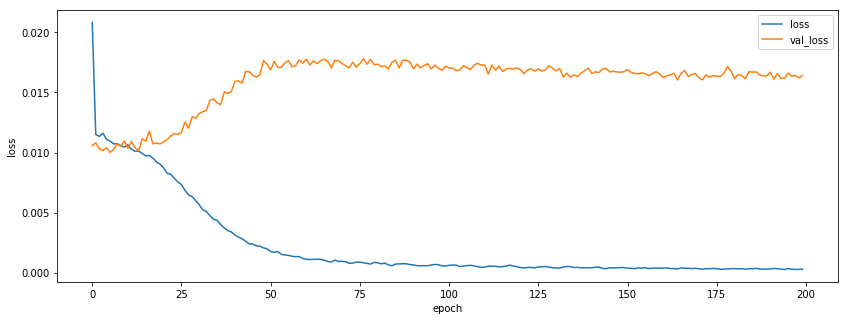

In [21]:
filename = ipynb_title + "__epochs_loss.png"

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1,1,1)

ax.plot(range(epochs), history.history['loss'], label='loss')
ax.plot(range(epochs), history.history['val_loss'], label='val_loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend() 

fig.savefig(fname=str(plot_images_Path / filename))
plt.show()

# End